In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob, re

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, plot_activation_energy, select_range

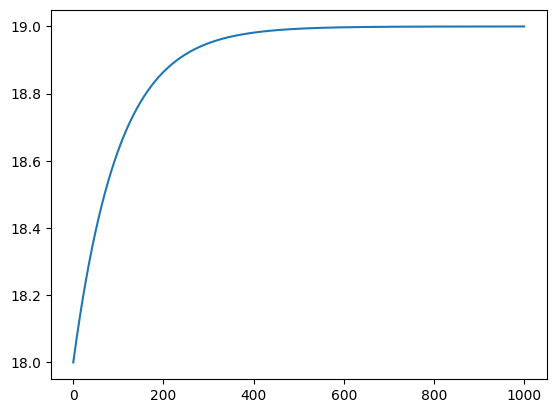

In [310]:
x = np.linspace(0, 1000, 1000)
y = 19 - np.exp(-x/100)
plt.plot(x, y)

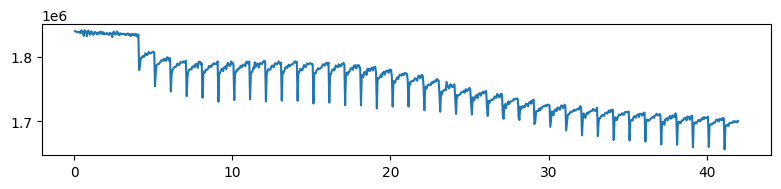

In [306]:
file = './Saved_data/rheed_data/selected/350C_second250shots_secondorder_midgrowth.txt'
data = np.loadtxt(file)
data = select_range(data, 0, 42)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.tight_layout()
plt.show()

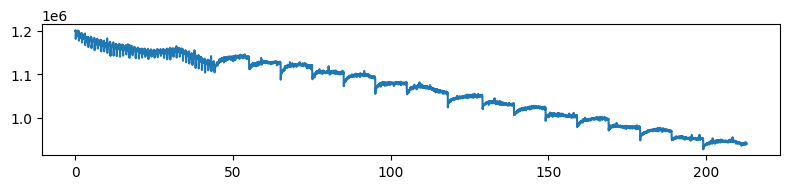

In [2]:
file = './Saved_data/rheed_data/selected/300C_second300shots_secondorder_midgrowth.txt'
data = np.loadtxt(file)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.tight_layout()
plt.show()

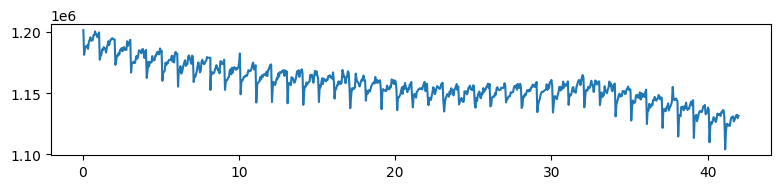

In [3]:
expo_time = 50
camera_freq = 1000/expo_time
laser_freq = 1
viz_curves=True
viz_fittings=True
viz_ab=False
fit_settings = {'step_size':3, 'prominence':10, 'mode':'valid', 'length':None, 'savgol_window_order': (5, 3), 'pca_component': 3, 'I_diff': None, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1], 'n_std':3, 'trim_first':0, 'tune_tail':False}

file = './Saved_data/rheed_data/selected/300C_second300shots_secondorder_midgrowth.txt'
data = np.loadtxt(file)
data = select_range(data, 0, 42)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.tight_layout()
plt.show()

In [4]:
from m3_learning.RHEED.Analysis import detect_peaks, process_rheed_data , fit_exp_function
from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz

In [62]:
sample_x, sample_y = data[:,0], data[:,1]

step_size = fit_settings['step_size']
prominence = fit_settings['prominence']
mode = fit_settings['mode']

# plt.plot(sample_x, sample_y)
# plt.show()

x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=laser_freq, step_size=step_size, prominence=prominence, mode=mode)

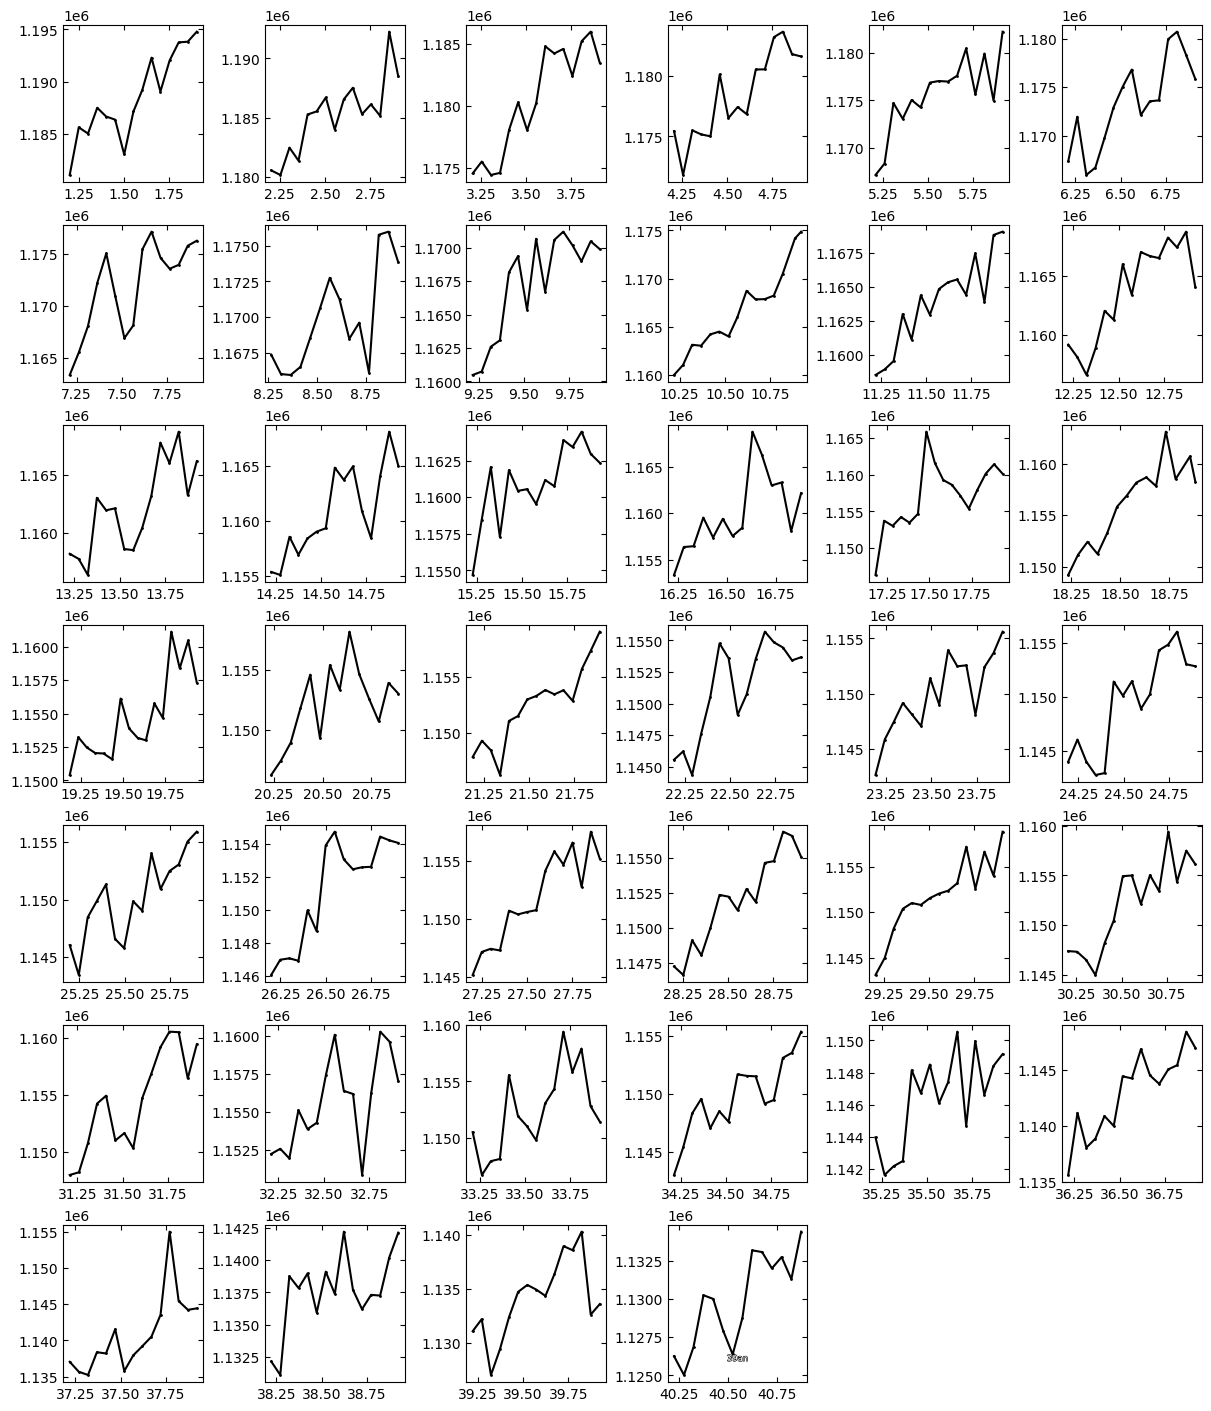

In [63]:
xs_sample, ys_sample = xs[::1], ys[::1]
fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

(40, 14) (40, 14)


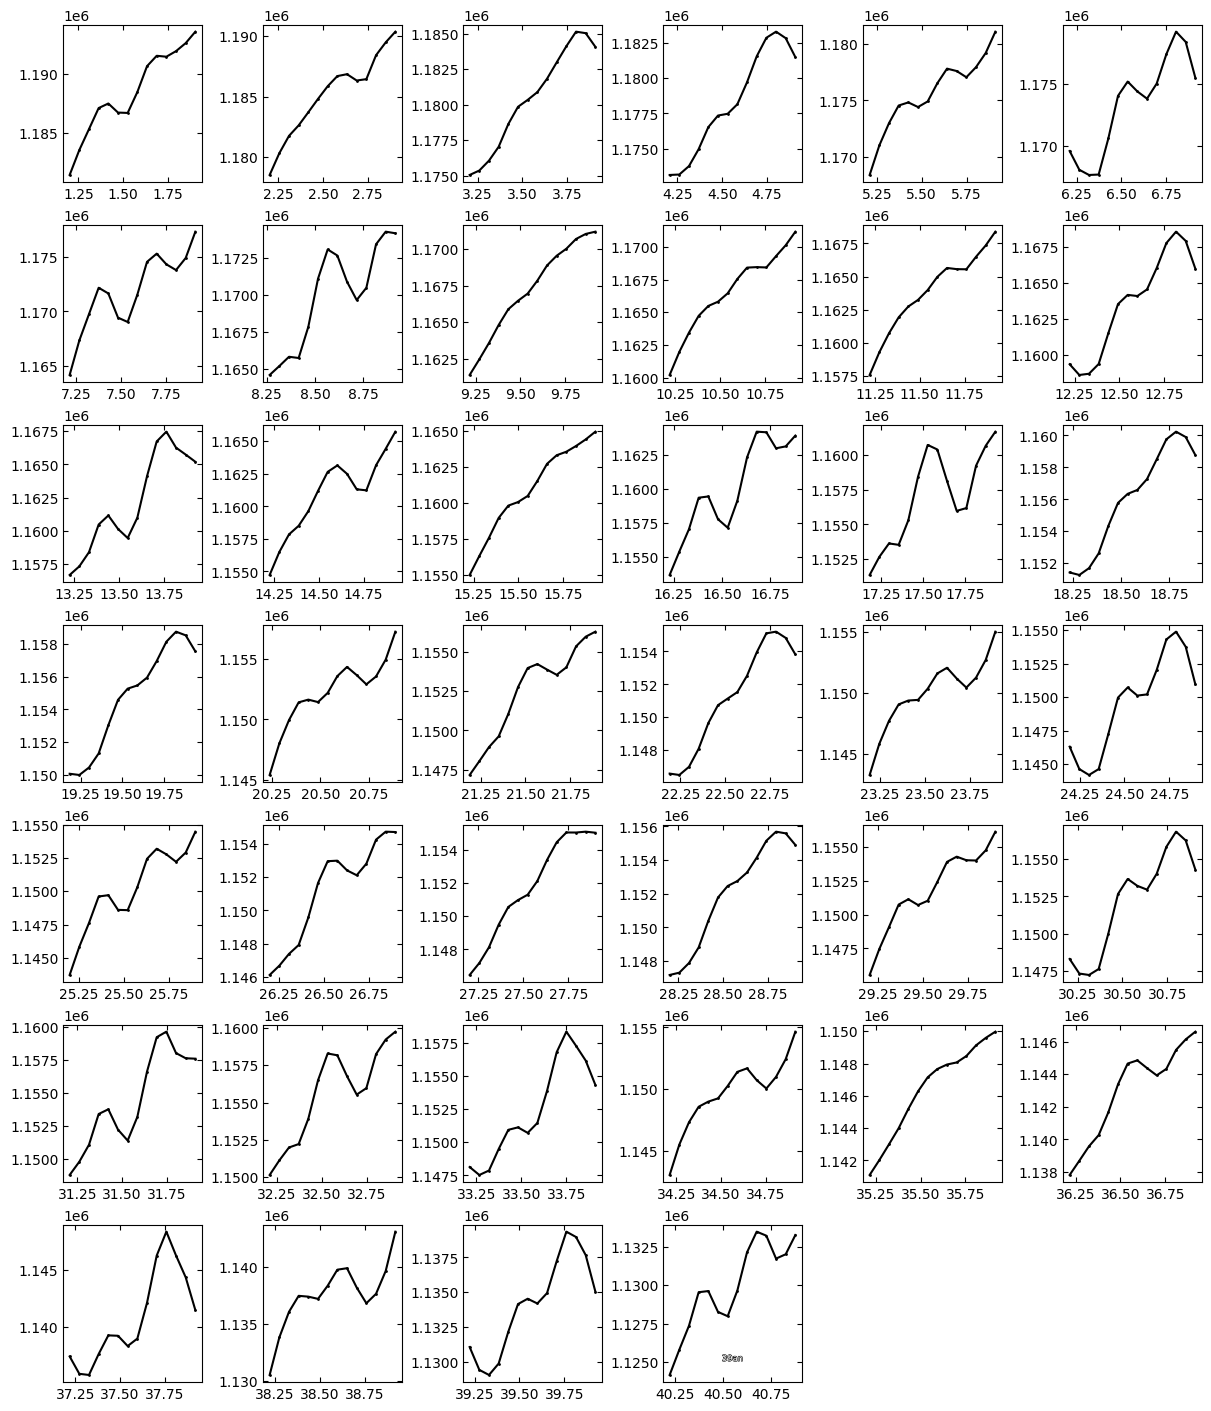

In [196]:
fit_settings = {'step_size':3, 'prominence':10, 'mode':'valid', 'length':None, 'savgol_window_order': (3, 2), 'pca_component': 3, 'I_diff': None, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1], 'n_std':3, 'trim_first':0, 'tune_tail':False}

xs, ys = process_rheed_data(xs, ys, length=fit_settings['length'], savgol_window_order=fit_settings['savgol_window_order'], 
                           pca_component=fit_settings['pca_component'])   
xs.shape, ys.shape
fig, axes = layout_fig(len(ys), mod=6, figsize=(12,2*len(ys)//6+1), layout='compressed')
Viz.show_grid_plots(axes, xs, ys, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

In [308]:
from scipy.optimize import curve_fit
# use simplified version to avoid overfitting to wrong fitting function
def taylor_expansion(x, b, tau):
    # return b - (np.exp(-x/tau) + np.exp(-x/(tau))**2/2 - np.exp(-x/(tau))**3/3 + np.exp(-x/(tau))**4/4 - np.exp(-x/(tau))**5/5 + np.exp(-x/(tau))**6/6 - np.exp(-x/(tau))**7/7 + np.exp(-x/(tau))**8/8 - np.exp(-x/(tau))**9/9 + np.exp(-x/(tau))**10/10)
    return b - np.exp(-x/tau)
    
def puiseux_series(x, b, tau):
    return b + np.log(x/tau) - x/(2*tau) 

def fit_tau(xs, ys, func):

    b_list, tau_list, ys_log_fit, ys_log, ys_fit, labels, labels_log = [], [], [], [], [], [], []
    for i, (x, y) in enumerate(zip(xs, ys)):
        x_nor = x - x[0]

        # y0 = np.max( [np.mean(y[-3:]), np.max(y[-3:])] )
        # y_nor_log = np.log((y/y0))
        # y_init = np.min(y[:3])
        # y_nor = y - y_init
        # y_nor = [y if y > 1 else 1 for y in y_nor]
        # y_nor_log = np.log(y_nor)
        y_nor_log = np.log(y)

        # plt.plot(x_nor, y_nor_log)
        # plt.show()
        if func == 'taylor_expansion':
            params, params_covariance = curve_fit(taylor_expansion, x_nor, y_nor_log, absolute_sigma=False)
        elif func == 'puiseux_series':
            params, params_covariance = curve_fit(puiseux_series, x_nor, y_nor_log, absolute_sigma=False)
        # params, params_covariance = curve_fit(func, x_nor, y_nor_log, absolute_sigma=False) 
        b, tau = params

        if func == 'taylor_expansion':
            y_fit = taylor_expansion(x_nor, b, tau)
            labels_log.append(f'index {i+1}:\nlnI={b:.2f}-exp(-t/{tau:.2f})')
            labels.append(f'index {i+1}:\nI={np.exp(b):.2E}[1-exp(-t/{tau:.2f})]')
        elif func == 'puiseux_series':
            y_fit = puiseux_series(x_nor, b, tau)
            labels.append(f'index {i+1}:\nlnI={b:.2f}-[ln(t/2{tau:.2f})-t/(2{tau:.2f})]')

        b_list.append(b)
        tau_list.append(tau)
        ys_log.append(y_nor_log)
        ys_log_fit.append(y_fit)
        ys_fit.append(np.exp(y_fit))

# b - ( np.log(x/tau) + x/(2*tau) - x**2/(24*tau**2) )
    return b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels

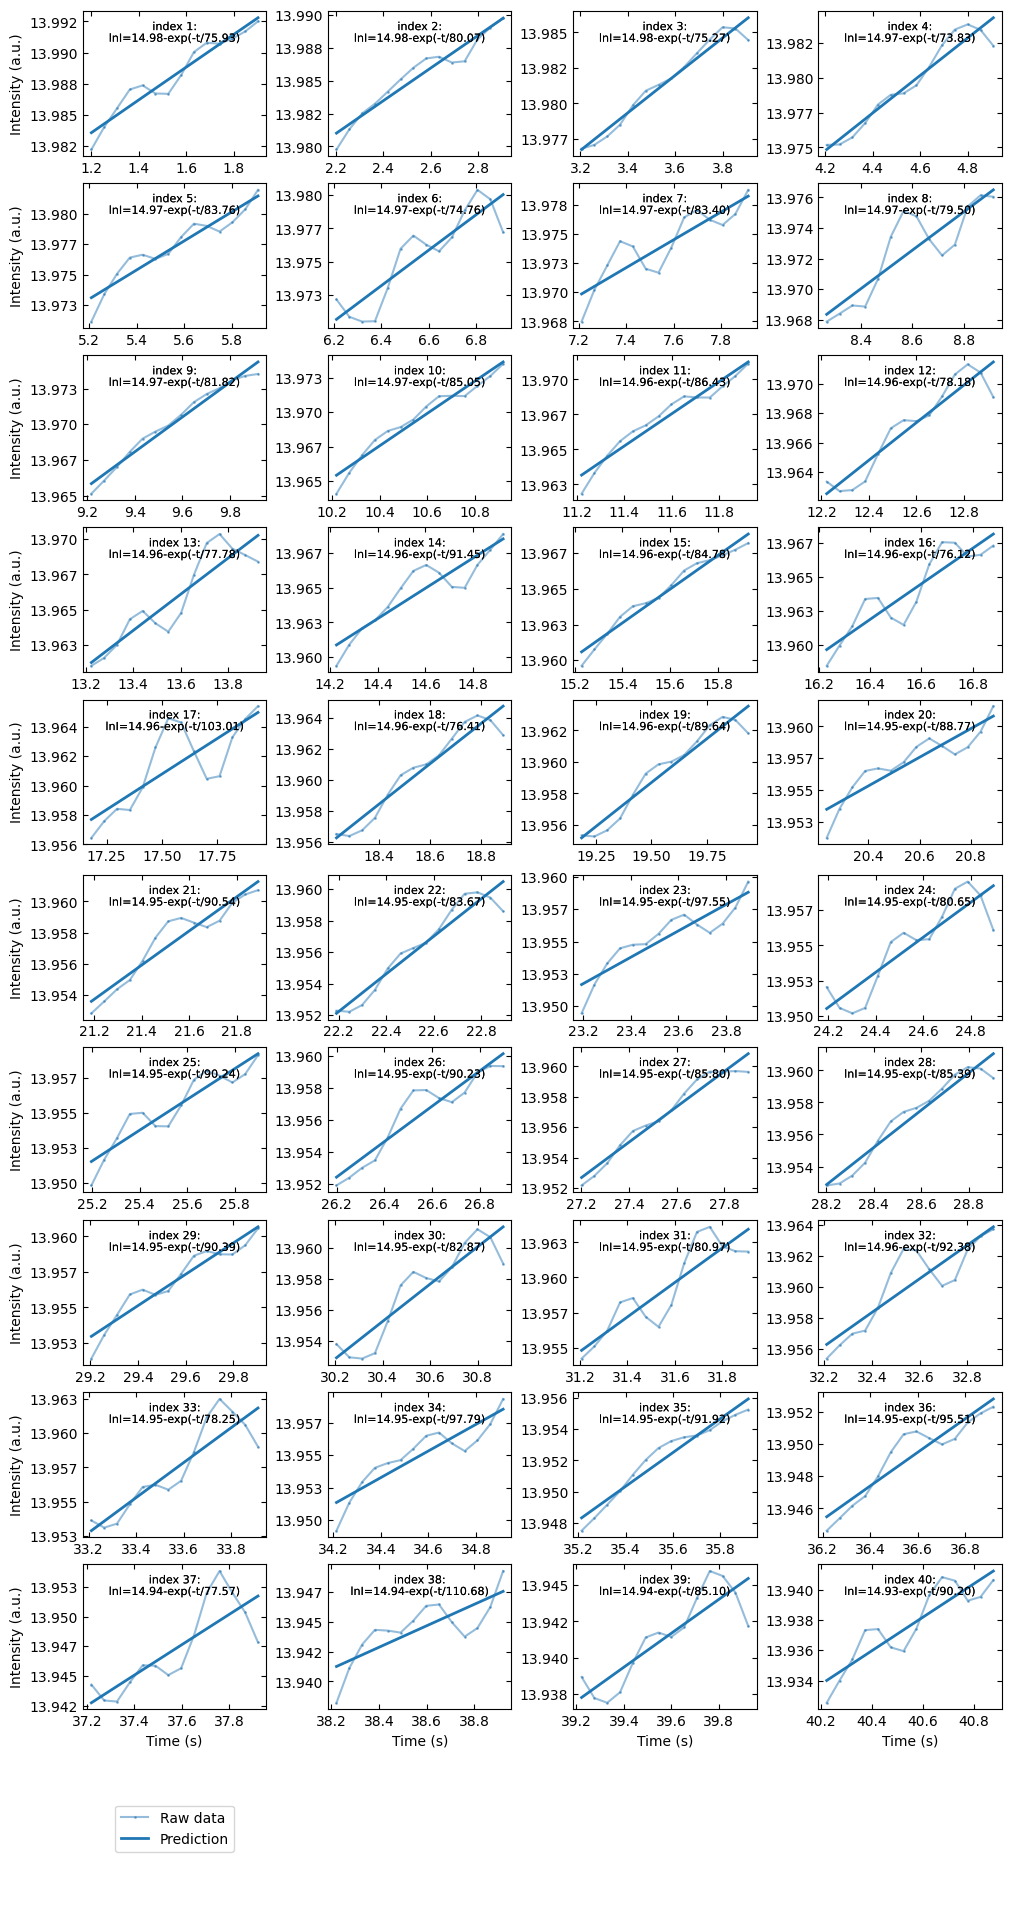

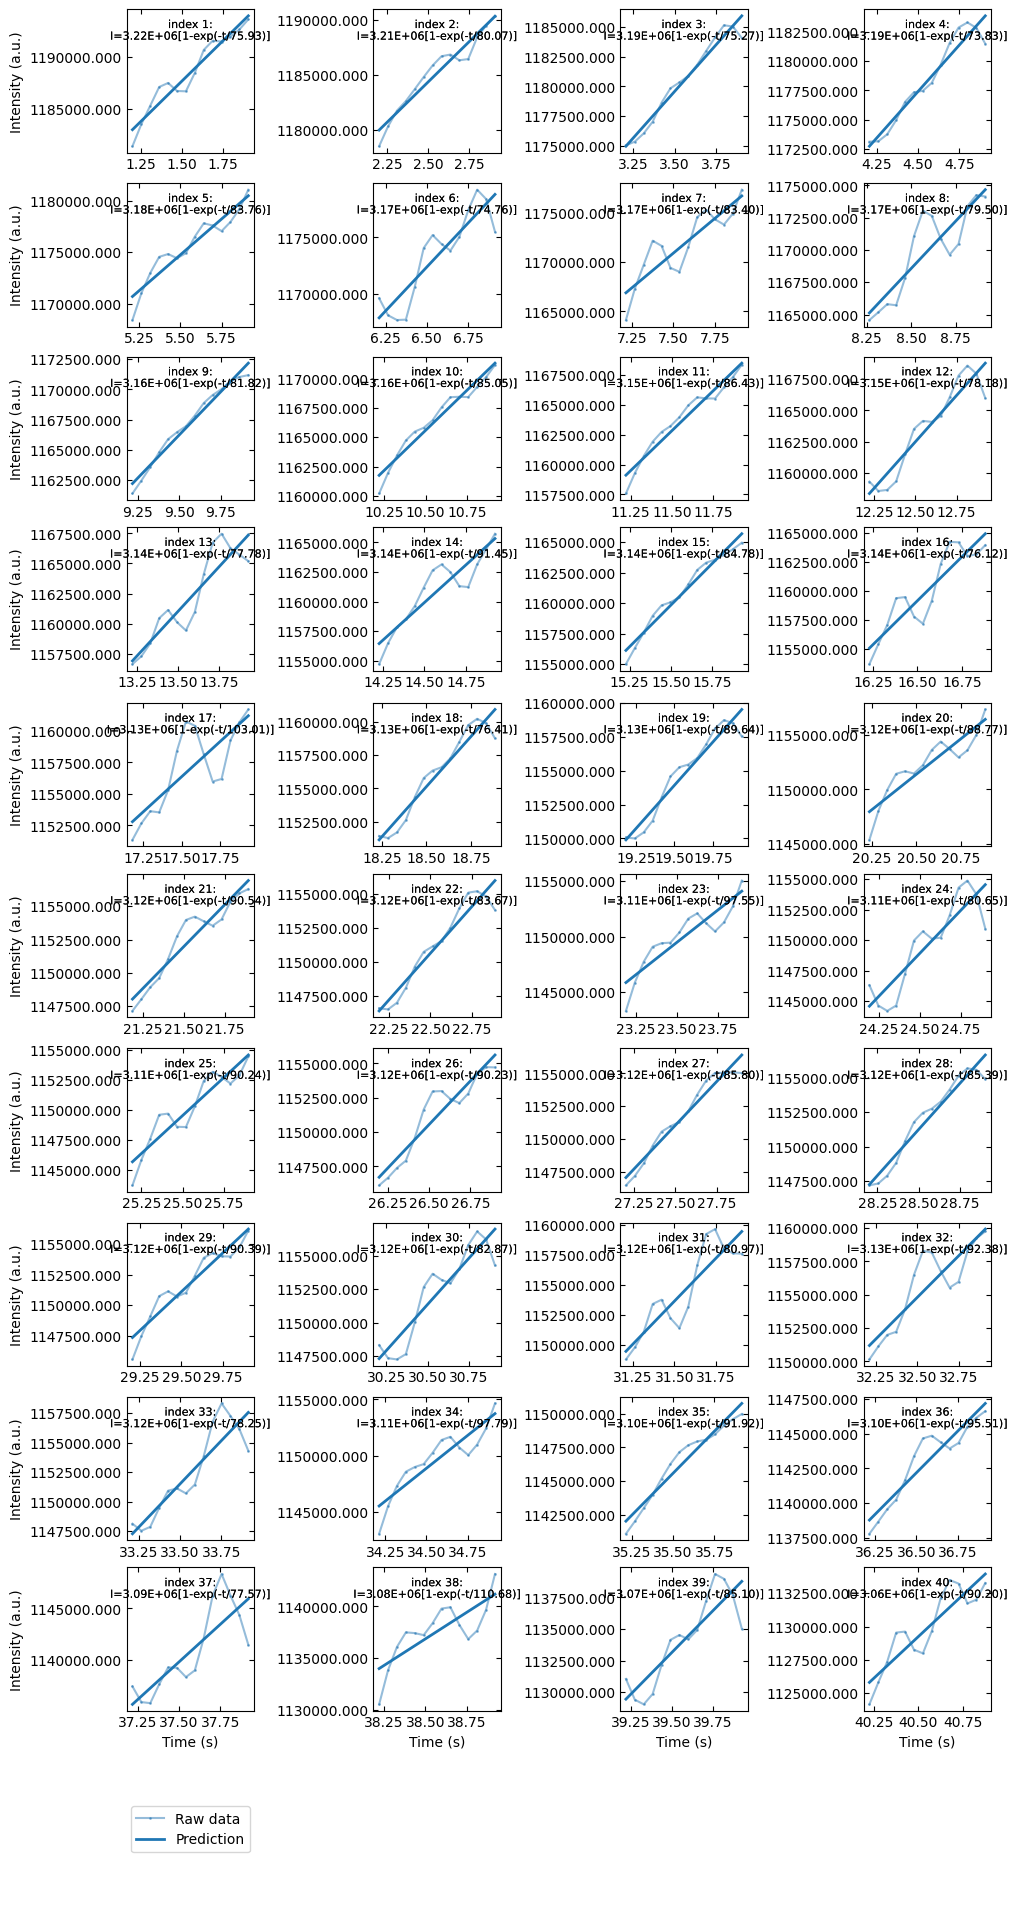

In [309]:
b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels = fit_tau(xs, ys, func='taylor_expansion')

Viz.plot_fit_details(xs, ys_log, ys_log_fit, y3=None, labels=labels_log, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)
Viz.plot_fit_details(xs, ys, ys_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)

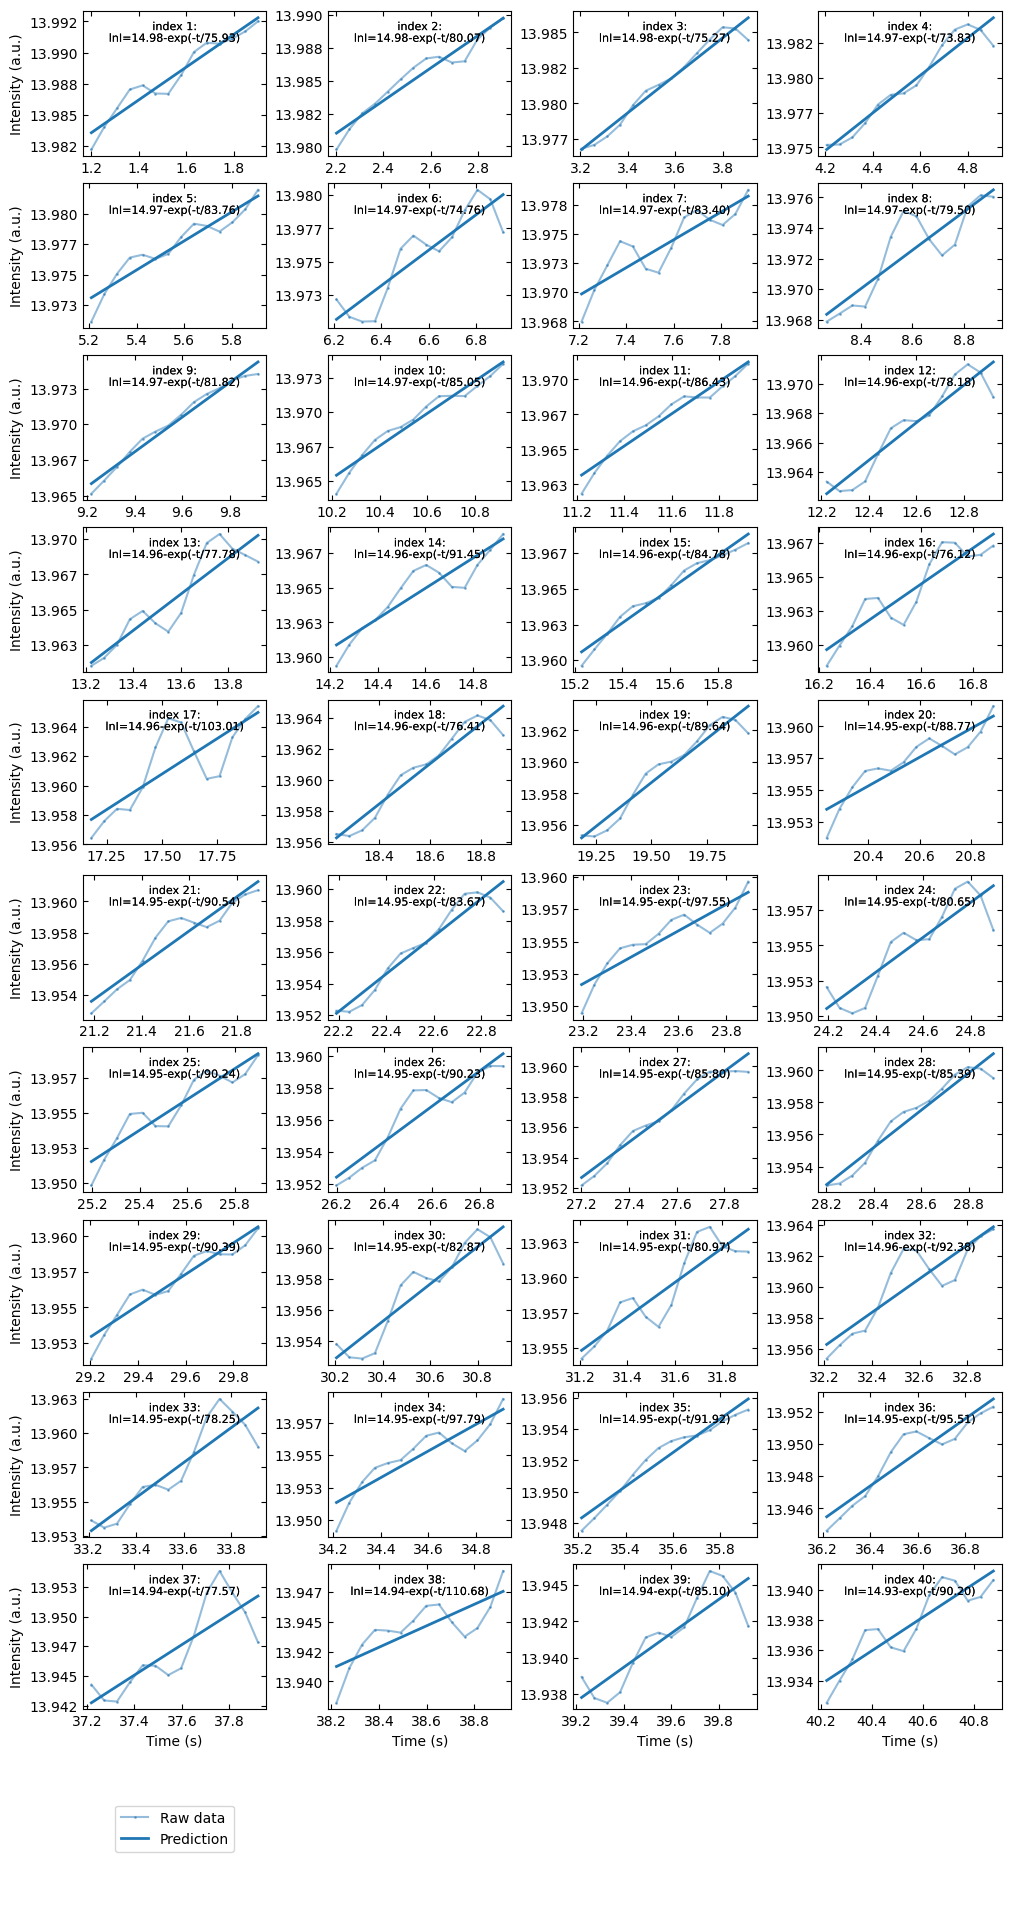

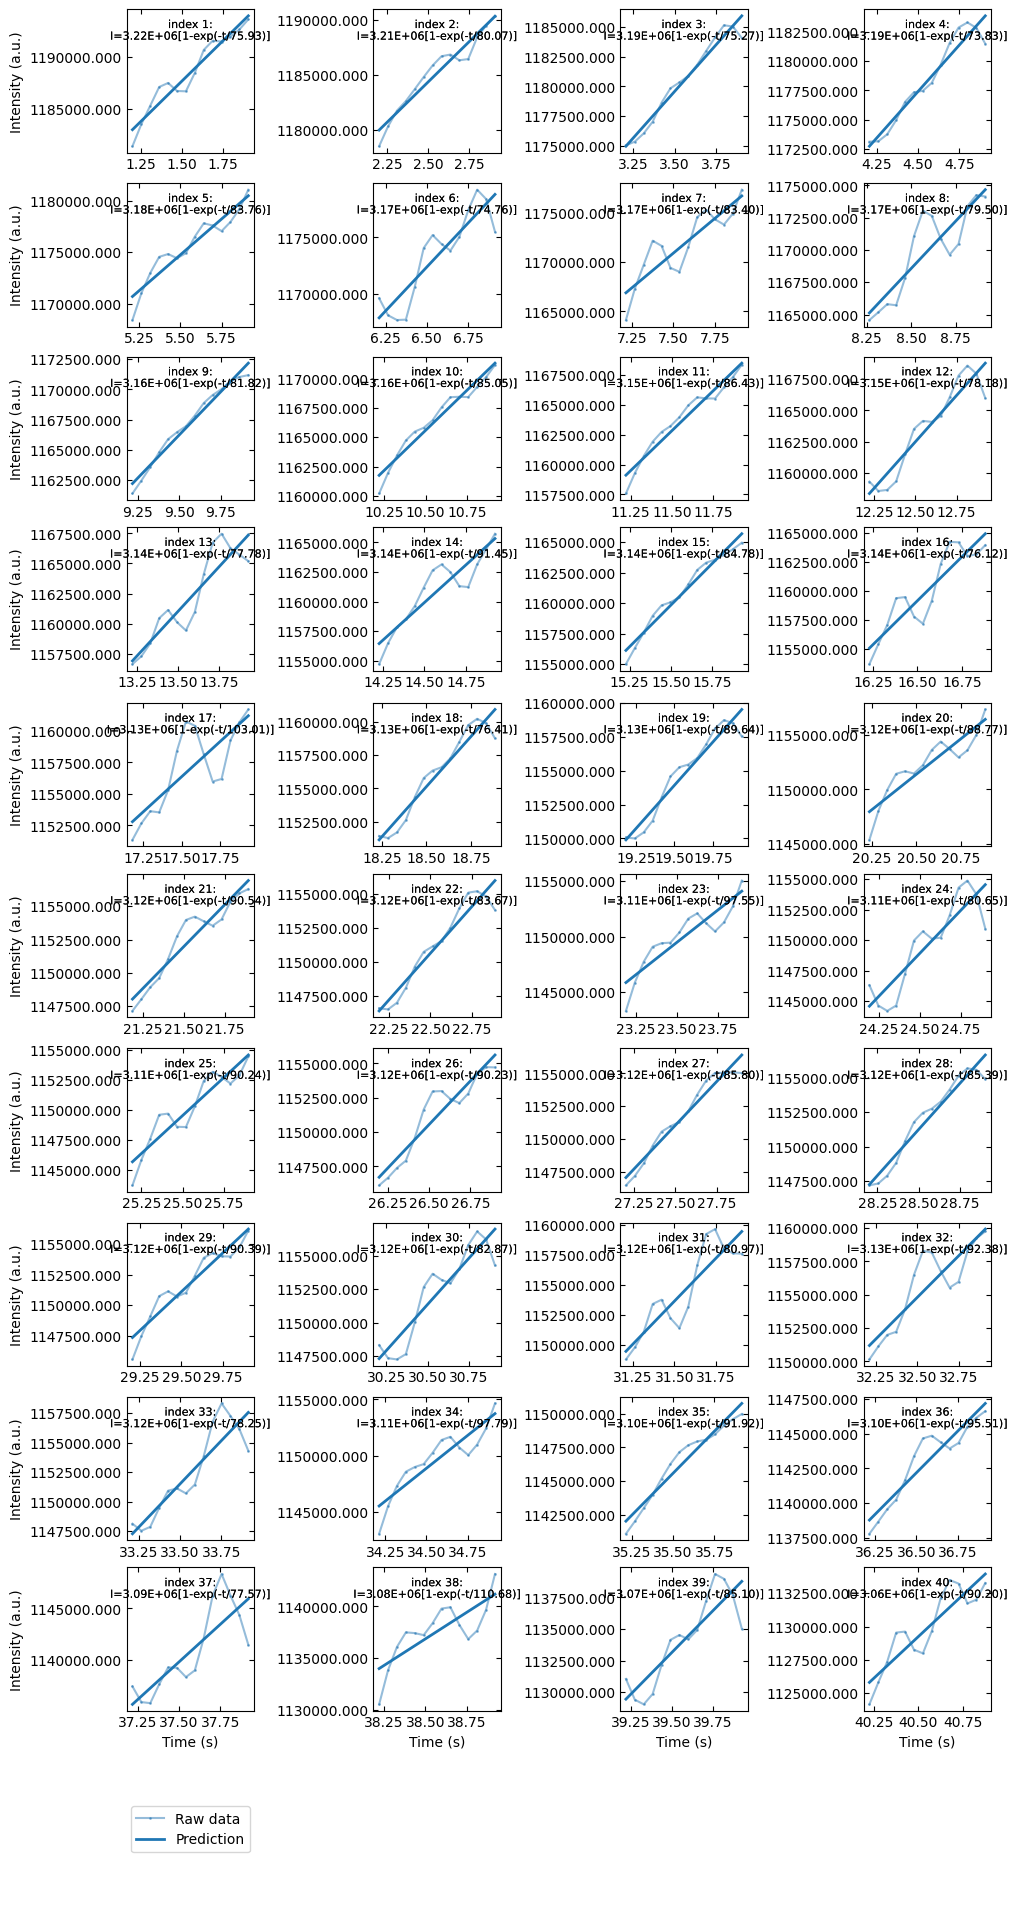

In [288]:
b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels = fit_tau(xs, ys, func='taylor_expansion')

Viz.plot_fit_details(xs, ys_log, ys_log_fit, y3=None, labels=labels_log, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)
Viz.plot_fit_details(xs, ys, ys_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)

C:\Users\yig319\AppData\Local\Temp\ipykernel_25680\819959384.py:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)
C:\Users\yig319\AppData\Local\Temp\ipykernel_25680\819959384.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x), y)


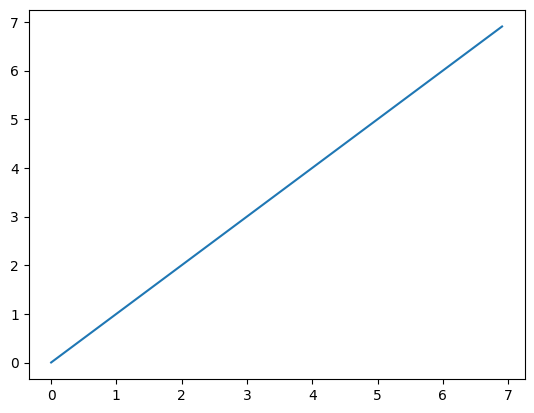

In [266]:
x = np.linspace(0, 1000, 1000)
y = np.log(x)
plt.plot(np.log(x), y)

In [ ]:
def puiseux_series(x, b, tau):
    # return b - (np.exp(-x/tau) + np.exp(-x/(tau))**2/2 - np.exp(-x/(tau))**3/3 + np.exp(-x/(tau))**4/4 - np.exp(-x/(tau))**5/5 + np.exp(-x/(tau))**6/6 - np.exp(-x/(tau))**7/7 + np.exp(-x/(tau))**8/8 - np.exp(-x/(tau))**9/9 + np.exp(-x/(tau))**10/10)
    return b - np.exp(-x/tau) 
    # return b + np.log(x/tau) - x/(2*tau) 
    
b = 21
tau = 1000
x = np.linspace(0, 1, 100)
y = puiseux_series(x, b, tau)
plt.plot(x, y)

C:\Users\yig319\AppData\Local\Temp\ipykernel_25680\2179585620.py:8: RuntimeWarning: divide by zero encountered in log
  return b + np.log(x/tau) - x/(2*tau)


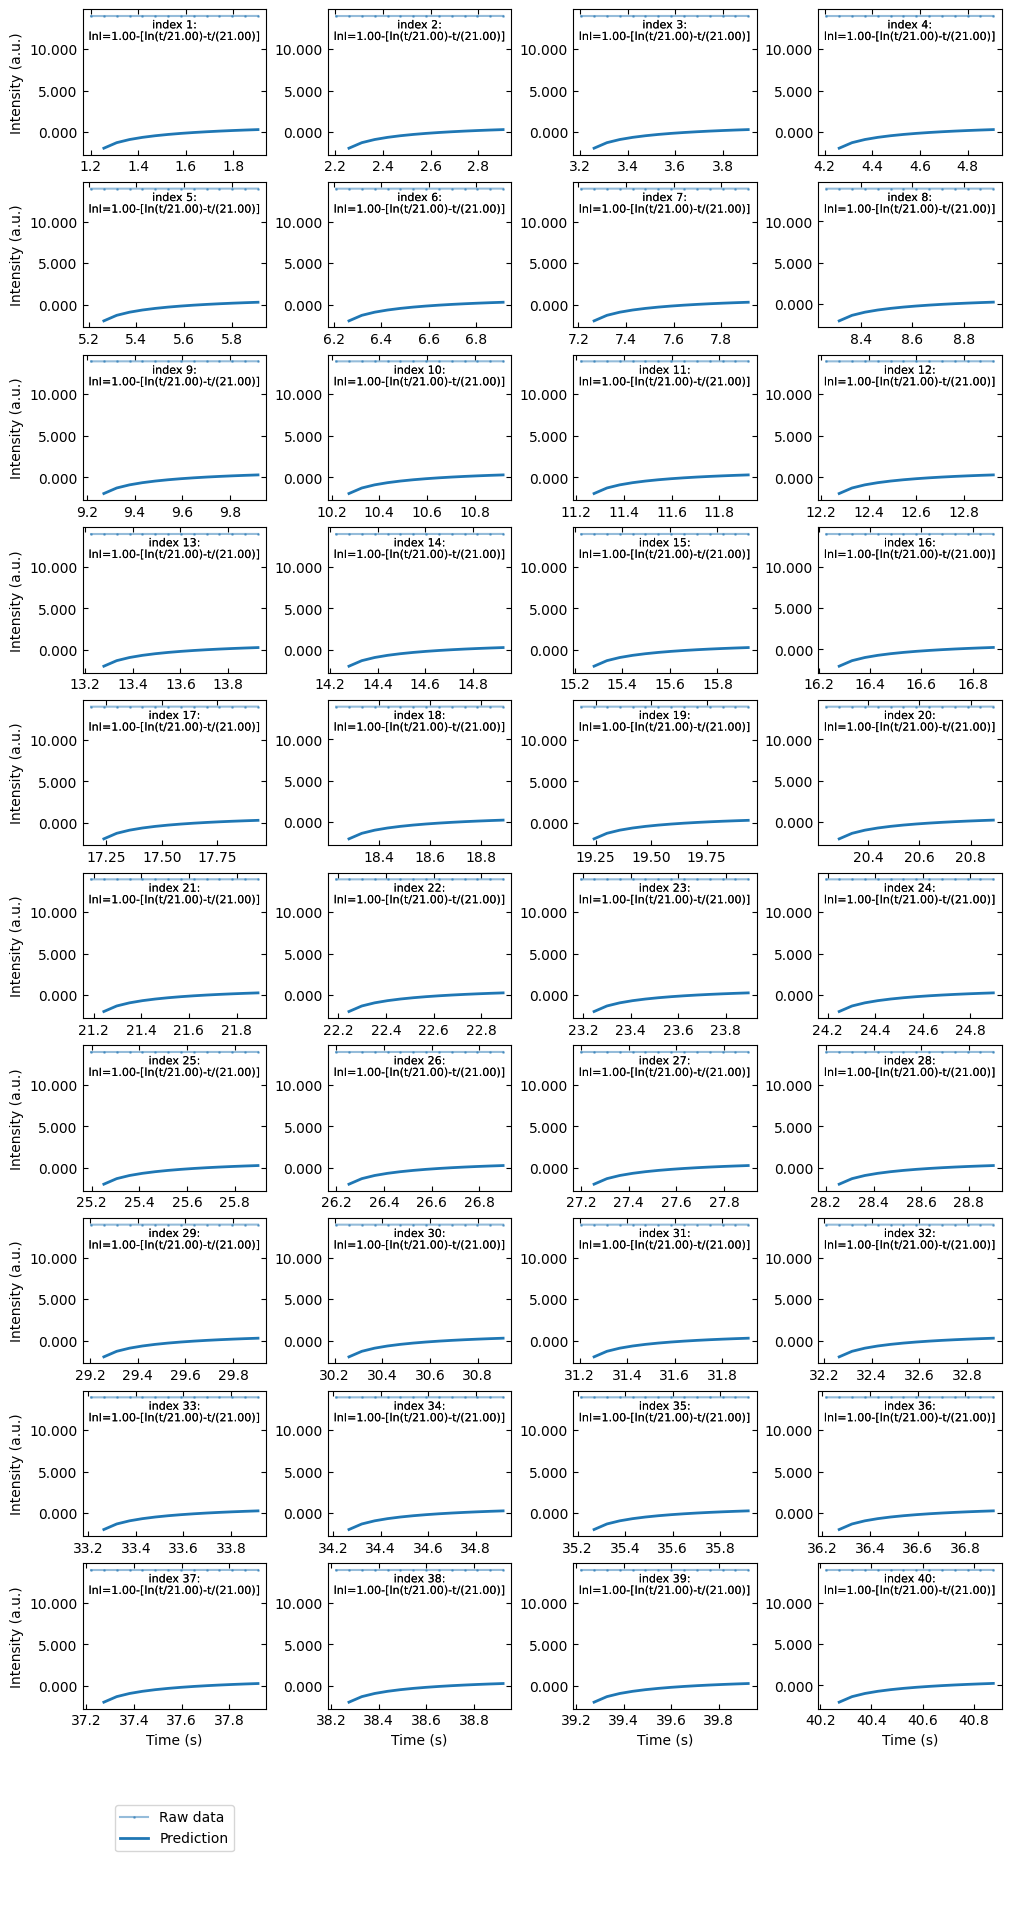

In [243]:
b_list, tau_list, ys_log_fit, ys_log, labels = fit_tau(xs, ys, func='puiseux_series')
Viz.plot_fit_details(xs, ys_log, ys_log_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)

In [141]:
np.log(1)

0.0

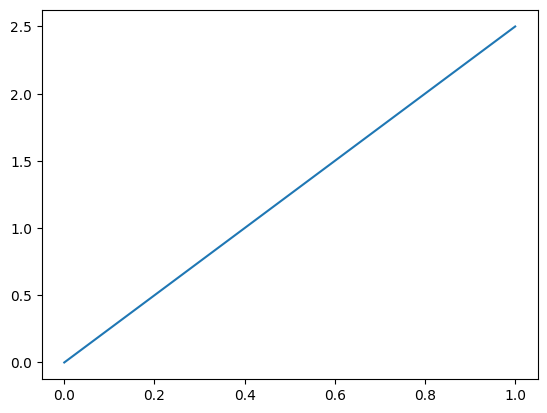

In [142]:
x = np.linspace(0, 1, 100)
y = x/0.4
plt.plot(x, y)

In [145]:
1-np.exp(-x/0.4)

array([0.00249688, 0.0273464 , 0.05157688, 0.07520373, 0.098242  ,
       0.12070635, 0.14261107, 0.16397011, 0.18479705, 0.20510516,
       0.22490736, 0.24421626, 0.26304413, 0.28140298, 0.29930447,
       0.31676   , 0.33378069, 0.35037736, 0.36656058, 0.38234065,
       0.39772761, 0.41273125, 0.42736113, 0.44162655, 0.45553659,
       0.46910012, 0.48232575, 0.49522191, 0.5077968 , 0.52005843,
       0.5320146 , 0.54367292, 0.55504082, 0.56612552, 0.57693408,
       0.58747338, 0.59775013, 0.60777087, 0.61754197, 0.62706966,
       0.63636   , 0.6454189 , 0.65425213, 0.6628653 , 0.67126391,
       0.67945329, 0.68743866, 0.6952251 , 0.70281757, 0.7102209 ,
       0.7174398 , 0.72447886, 0.73134256, 0.73803528, 0.74456128,
       0.7509247 , 0.75712959, 0.76317991, 0.76907951, 0.77483214,
       0.78044146, 0.78591104, 0.79124436, 0.79644483, 0.80151574,
       0.80646032, 0.81128173, 0.81598303, 0.82056721, 0.82503719,
       0.82939581, 0.83364586, 0.83779002, 0.84183095, 0.84577

In [146]:
np.log(1-np.exp(-x/0.4))

array([-5.99271429, -3.59917038, -2.9646818 , -2.5875544 , -2.32032143,
       -2.11439455, -1.94763414, -1.80807114, -1.68849707, -1.58423244,
       -1.49206667, -1.40970114, -1.33543345, -1.26796756, -1.20629394,
       -1.14961089, -1.09727113, -1.04874454, -1.00359148, -0.96144332,
       -0.92198791, -0.88495862, -0.85012589, -0.81729067, -0.78627923,
       -0.75693907, -0.72913557, -0.70274932, -0.67767391, -0.65381411,
       -0.63108434, -0.60940746, -0.58871362, -0.56893946, -0.55002727,
       -0.53192434, -0.51458245, -0.49795733, -0.48200824, -0.46669764,
       -0.45199084, -0.43785572, -0.42426249, -0.41118348, -0.39859291,
       -0.38646679, -0.37478267, -0.3635196 , -0.35265792, -0.34217923,
       -0.33206624, -0.3223027 , -0.31287331, -0.30376365, -0.29496012,
       -0.2864499 , -0.27822085, -0.27026148, -0.26256092, -0.25510887,
       -0.24789555, -0.24091168, -0.23414843, -0.22759742, -0.22125067,
       -0.21510058, -0.2091399 , -0.20336173, -0.19775946, -0.19

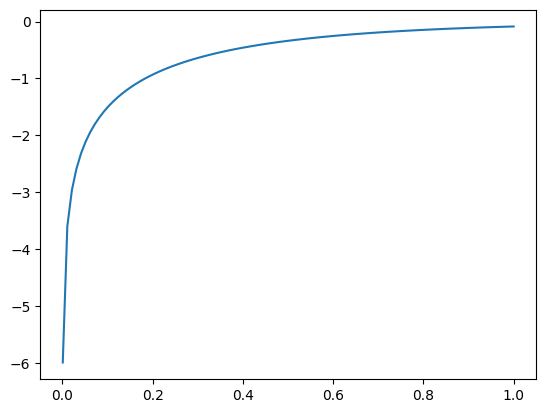

In [143]:
x = np.linspace(1e-3, 1, 100)
y = np.log(1-np.exp(-x/0.4))
plt.plot(x, y)

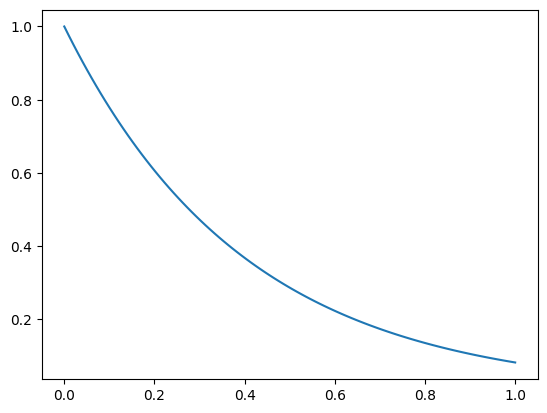

In [147]:
x = np.linspace(0, 1, 100)
y = np.exp(-x/0.4)
plt.plot(x, y)

In [67]:
x, y = xs[0], ys[0]

In [75]:
[y, y-y[0], np.log(y), np.log(y)-np.log(y[0])]

[[1181062.0,
  1185622.0,
  1185025.0,
  1187495.0,
  1186660.0,
  1186357.0,
  1183024.0,
  1187141.0,
  1189208.0,
  1192295.0,
  1189049.0,
  1192028.0,
  1193754.0,
  1193823.0,
  1194783.0],
 array([    0.,  4560.,  3963.,  6433.,  5598.,  5295.,  1962.,  6079.,
         8146., 11233.,  7987., 10966., 12692., 12761., 13721.]),
 array([13.98192459, 13.98577809, 13.98527443, 13.9873566 , 13.9866532 ,
        13.98639783, 13.98358443, 13.98705845, 13.9887981 , 13.99139058,
        13.98866439, 13.99116662, 13.99261352, 13.99267132, 13.99347514]),
 array([0.        , 0.0038535 , 0.00334984, 0.00543201, 0.0047286 ,
        0.00447323, 0.00165984, 0.00513386, 0.00687351, 0.00946599,
        0.00673979, 0.00924202, 0.01068893, 0.01074673, 0.01155055])]

In [82]:
b_list, tau_list, ys_log_fit, ys_log, labels = fit_tau([x,x], [y, y-y[0]+1])

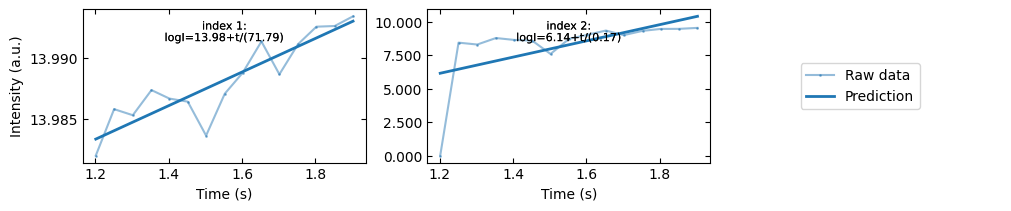

In [83]:
Viz.plot_fit_details([x,x], ys_log, ys_log_fit, y3=None, labels=labels, figsize=(10, 2), mod=3, 
                     style='presentation', logscale=False)

C:\Users\yig319\AppData\Local\Temp\ipykernel_25680\839202676.py:6: RuntimeWarning: divide by zero encountered in log
  axes[3].plot(x, np.log(y-y[0]))


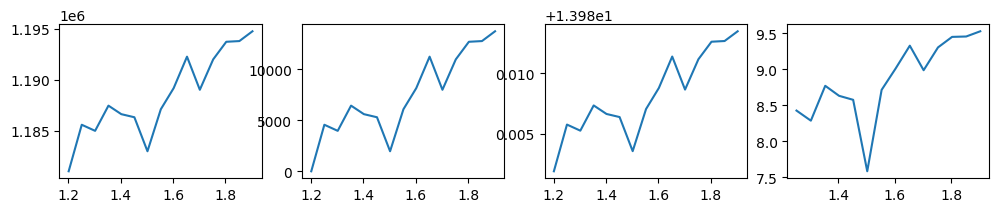

In [72]:
fig, axes = plt.subplots(1, 4, figsize=(12,2))


axes[0].plot(x, y)
axes[1].plot(x, y-y[0])
axes[2].plot(x, np.log(y))
axes[3].plot(x, np.log(y-y[0]))


In [65]:
b_list, tau_list, ys_log_fit, ys_log, labels = fit_tau(xs, ys, fit_settings = {'bounds':[0.01, 1], 'p_init':[100, 2]})
Viz.plot_fit_details(xs, ys_log, ys_log_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, 
                     style='presentation', logscale=False)

In [ ]:
parameters_all, x_list_all, info = fit_curves(xs, ys, x_peaks, sample_x, fit_settings)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info

(40, 14) (40, 14)


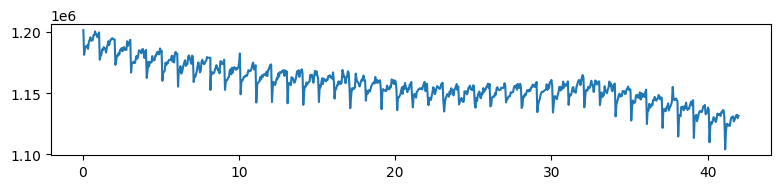

(40, 14) (40, 14)


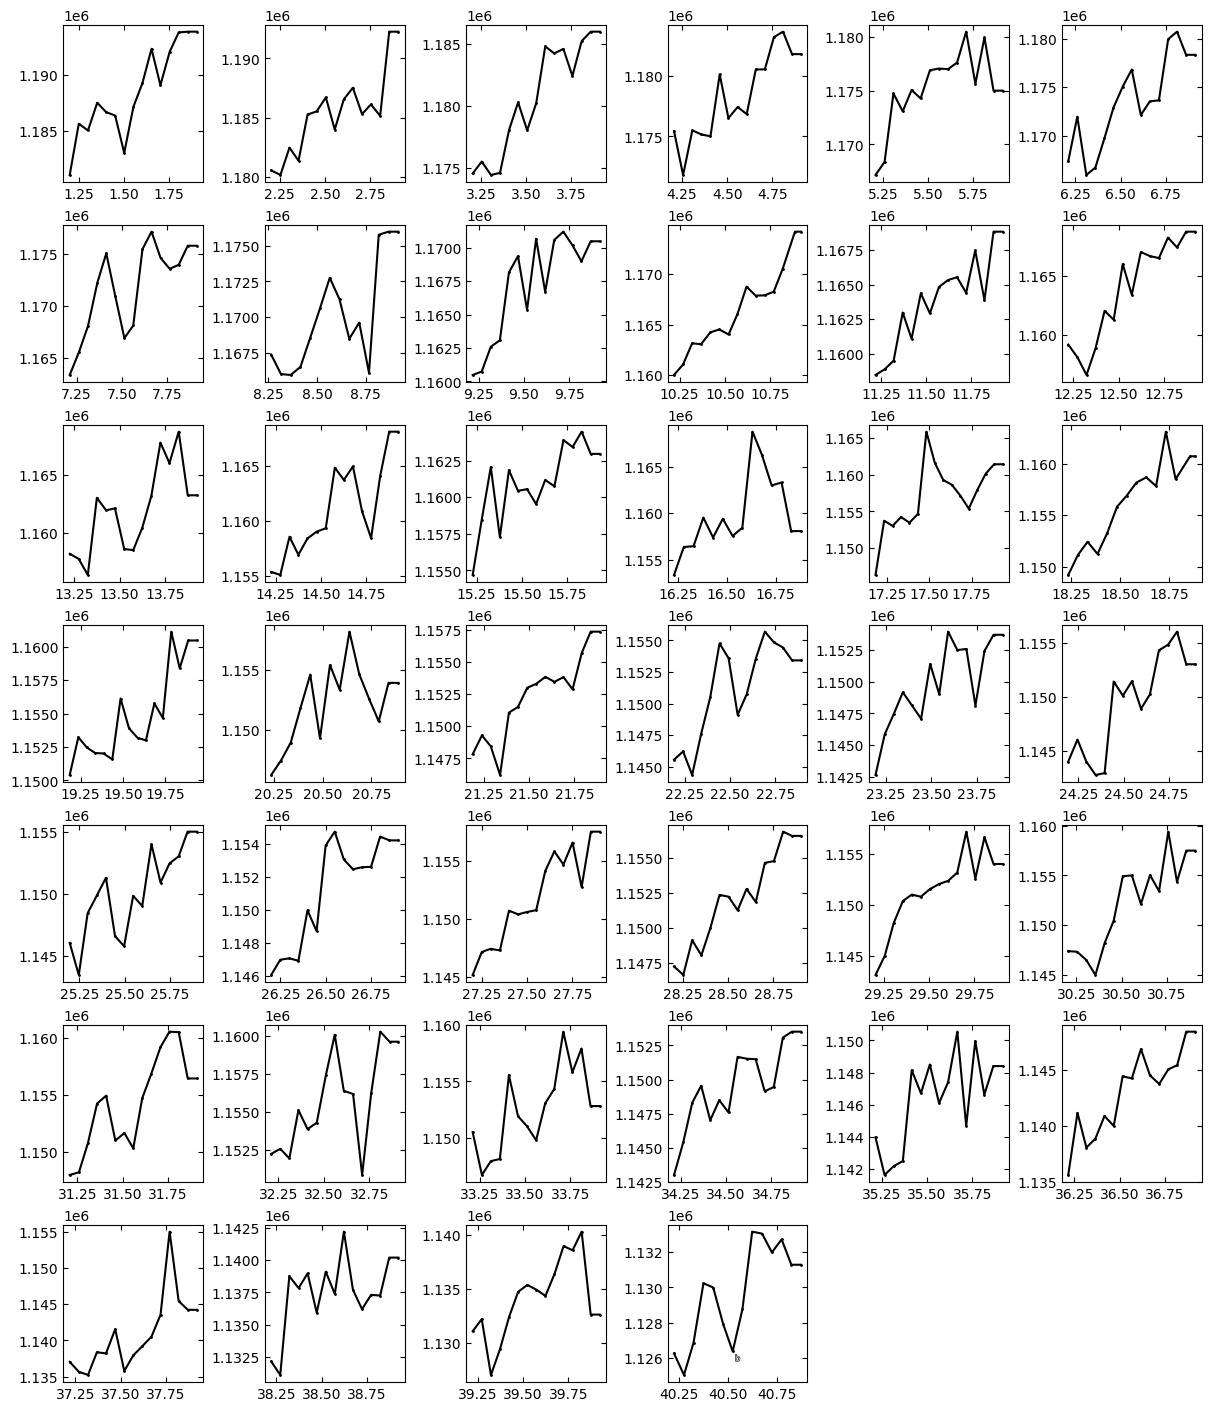

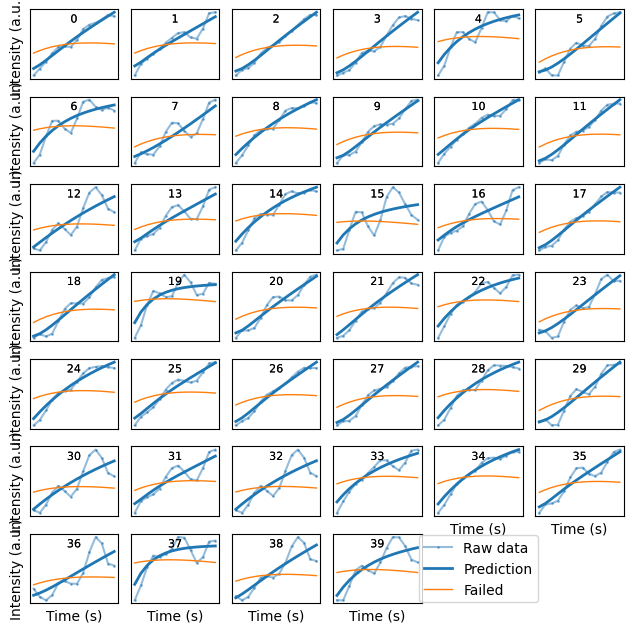

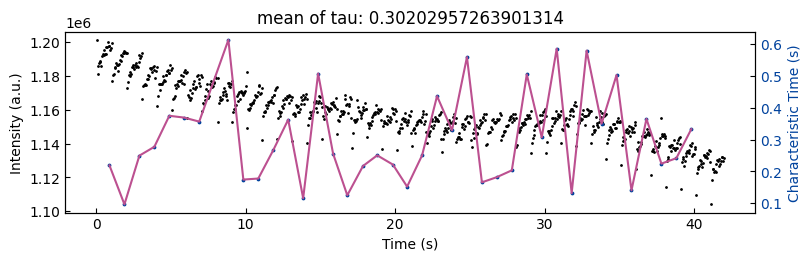

In [23]:
file = './Saved_data/rheed_data/selected/300C_second300shots_secondorder_midgrowth.txt'
data = np.loadtxt(file)
data = select_range(data, 0, 42)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.tight_layout()
plt.show()

expo_time = 50
camera_freq = 1000/expo_time
laser_freq = 1
viz_curves=True
viz_fittings=True
viz_ab=False
fit_settings = {'step_size':3, 'prominence':10, 'mode':'valid','savgol_window_order': (5, 3), 'pca_component': 3, 'I_diff': None, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1], 'n_std':3, 'trim_first':0, 'tune_tail':False}
parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, viz_curves, viz_fittings, viz_ab, fit_settings)